# San Francisco Traffic Collision Data Analysis


## Background:

San Francisco became the second city in the US to embrace Vision Zero in 2014, aiming for zero traffic fatalities by 2024. However, the [West Portal crash](https://abc7news.com/west-portal-crash-sfmta-findings-deadly-intersection-suspect/14551317/) on March 16 marked the [11th traffic fatality in San Francisco](https://app.powerbigov.us/view?r=eyJrIjoiMGNmMDdmNmQtMTA1Ni00NTFmLWI5YmQtNzZiNDU0YWE4NmJmIiwidCI6IjIyZDVjMmNmLWNlM2UtNDQzZC05YTdmLWRmY2MwMjMxZjczZiJ9) in 2024. As a resident who regularly bikes and walks in the city, I've observed what feels like a worsening trend in driver behavior over the years. However, I recognize that personal perceptions don't always align with reality. Therefore, I turned to the [Bicycle and Pedestrian Collision dataset from the San Francisco County Transportation Authority](https://safety.sfcta.org/) to explore the following questions:

    - Have collision trends shown any significant changes over time, particularly around the adoption of Vision Zero in 2014?

    - Which street is the most hazardous within San Francisco over the years, in terms of the number of collisions and fatalities?

    - How do pedestrian and bicycle accidents compare in terms of fatality rates? Is there a notable difference in outcomes for pedestrians versus cyclists?

### Acknowledgement:

In this analysis report, it's important to recognize biases stemming from location-specific or time-specific factors, such as the impact of COVID-19 lockdowns in the San Francisco Bay Area or the rise of remote work reducing traffic congestion and potentially affecting traffic fatalities. Addressing these biases ensures a more accurate interpretation of the data and informs effective road safety strategies.

Furthermore, it's worth noting that the dataset only includes the year of collisions rather than the exact dates. This limitation could lead to minor calculation errors, particularly around significant milestone events such as the adoption of Vision Zero and the onset of COVID-19 lockdowns.

**04/22/2024 Edit**: This document was originally created in a Jupyter notebook as a notebook (.ipynb) file. Apologies for any inconvenience caused by formatting errors within this Colab environment.

**08/12/2025 Edit**: Replaced px.scatter_mapbox with px.scatter_map per deprecation guidance, removed the Mapbox token dependency, added Pedestrian/Bicycle layer toggles, and tightened data validation. Core questions, filters, and findings remain unchanged.

## Import Tools and Perform System Check

In [1]:
import sys
import os, io, sys, textwrap, warnings
import re
import pandas as pd
import numpy as np
import sqlite3 as db
import pprint
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

print(f"* Python version:\n{sys.version}\n")
print(f"* sqlite3 version: {db.version}")
print(f"* pandas version: {pd.__version__}")

* Python version:
3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:42:04) [MSC v.1943 64 bit (AMD64)]

* sqlite3 version: 2.6.0
* pandas version: 2.1.4


## Import the Dataset and Show the First 5 Rows to Understand the Data Headers

In [2]:
file_path = "sf_traffic_data_2022.csv"
db = pd.read_csv(file_path)

display(db[:5])

db['year'] = pd.to_datetime(db['year'], format='%Y')

# Find the maximum and minimum values of 'year' to understand the range
max_year = db['year'].max()
min_year = db['year'].min()

print("The date range from: \n", min_year, "\n to \n", max_year)

,geom,intersection_lat,intersection_lon,year,st_asgeojson,biccol,pedcol,bickill,pedkill,ambiccol,...,pmbickill,ampedkill,pmpedkill,street_names,bicinj,pedinj,ambicinj,pmbicinj,ampedinj,pmpedinj
0,POINT(-122.362687924 37.8118959065),37.811896,-122.362688,2008,"{""type"":""Point"",""coordinates"":[-122.362687924,...",0,1,0,1,0,...,0,0,1,"['HARRIET LN', 'HEALY AVE', 'NORTH GATE RD']",0,0,0,0,0,0
1,POINT(-122.362687924 37.8118959065),37.811896,-122.362688,2010,"{""type"":""Point"",""coordinates"":[-122.362687924,...",0,1,0,0,0,...,0,0,0,"['HARRIET LN', 'HEALY AVE', 'NORTH GATE RD']",0,1,0,0,1,0
2,POINT(-122.363147334 37.8119019961),37.811902,-122.363147,2011,"{""type"":""Point"",""coordinates"":[-122.363147334,...",0,1,0,0,0,...,0,0,0,"['I-80 E ON RAMP', 'I-80 EASTBOUND']",0,1,0,0,0,1
3,POINT(-122.363742766 37.8235744254),37.823574,-122.363743,2016,"{""type"":""Point"",""coordinates"":[-122.363742766,...",1,0,0,0,0,...,0,0,0,"['04TH TI ST', 'AVENUE N']",1,0,0,1,0,0
4,POINT(-122.367433795 37.8078191921),37.807819,-122.367434,2014,"{""type"":""Point"",""coordinates"":[-122.367433795,...",0,1,0,0,0,...,0,0,0,"['I-80 W ON RAMP', 'I-80 WESTBOUND']",0,1,0,0,1,0


The date range from: 
 2006-01-01 00:00:00 
 to 
 2022-01-01 00:00:00


## Dataset Breakdown:

- **geom**: Geographic coordinates of the collision incident.

- **intersection_lat**: Latitude of the intersection where the collision occurred.

- **intersection_lon**: Longitude of the intersection where the collision occurred.

- **year**: The year in which the collision took place.

- **st_asgeojson**: Geographic coordinates of the collision incident in GeoJSON format.

- **biccol**: The total number of bicycle collisions.

- **pedcol**: The total number of pedestrian collisions.

- **bickill**: The total number of bicyclists killed in the collisions.

- **pedkill**: The total number of pedestrians killed in the collisions.

- **ambiccol**: The number of bicycle collisions involving an ambulance.

- **pmbiccol**: The number of bicycle collisions involving a paramedic.

- **ampedcol**: The number of pedestrian collisions involving an ambulance.

- **pmpedcol**: The number of pedestrian collisions involving a paramedic.

- **ambickill**: The number of bicyclist fatalities in collisions involving an ambulance.

- **pmbickill**: The number of bicyclist fatalities in collisions involving a paramedic.

- **ampedkill**: The number of pedestrian fatalities in collisions involving an ambulance.

- **pmpedkill**: The number of pedestrian fatalities in collisions involving a paramedic.

- **street_names**: Names of streets or locations where the collisions occurred.

- **bicinj**: The total number of bicyclist injuries in the collisions.

- **pedinj**: The total number of pedestrian injuries in the collisions.

- **ambicinj**: The total number of injuries to others in bicycle collisions involving an ambulance.

- **pmbicinj**: The number of injuries to bicyclists in collisions involving a paramedic.

- **ampedinj**: The number of injuries to pedestrians in collisions involving an ambulance.

- **pmpedinj**: The number of injuries to pedestrians in collisions involving a paramedic.

## Examining Collision Trends Over Time

### 1. Have collision trends shown any significant changes over time, particularly around the adoption of Vision Zero in 2014?

### Vision Zero
The SFMTA website does not specify the exact adoption date for Vision Zero 2024 on https://www.visionzerosf.org/. To accommodate this uncertainty, I defined the post-Vision Zero date range as December 31, 2014, to March 15, 2020. This broader timeframe within 2014 allows for flexibility while excluding data after California announced lockdown measures, mitigating potential biases stemming from reduced traffic during lockdowns.

However, with the post-Vision Zero range spanning six years (2014-2020) and the pre-Vision Zero range covering eight years (2006-2014), there is a discrepancy in the duration of the two periods. To ensure a fairer comparison, I adjusted the lower bound of the pre-Vision Zero year to December 31, 2008, aligning both sets over a consistent six-year range.

In [3]:
###
#Convert the 'year' column to datetime format.
#Filter the dataset to obtain data for the pre and post Vision Zero periods.
#Group the data by year and count the number of collisions for each year.
#Calculate the average percentage change in collision rates for both pre and post Vision Zero periods.
#Display the total number of collisions for the pre and post Vision Zero periods.
#Present the average percentage change in collision rates for both periods.

###

# Make a copy of df
db_copy = db.copy()

# Convert the date column to a datetime format
db_copy['year'] = pd.to_datetime(db_copy['year'], format='%Y')

# Create a new column for total number of collisions
db_copy['total_col'] = db_copy['biccol'] + db_copy['pedcol']

# Filter the dataset
pre_vision_zero = db_copy[(db_copy['year'] <= '2014-12-31') & (db_copy['year'] >= '2008-12-31')]
post_vision_zero = db_copy[(db_copy['year'] > '2014-12-31') & (db_copy['year'] <= '2020-03-15')]

# Group the data by year and sum the total number of collisions for each year
pre_vz_collision_counts = pre_vision_zero.groupby(pre_vision_zero['year'].dt.year)['total_col'].sum()
post_vz_collision_counts = post_vision_zero.groupby(post_vision_zero['year'].dt.year)['total_col'].sum()

# Calculate the average percentage change for both groups
pre_vz_collision_avg_change = (pre_vz_collision_counts.pct_change().mean() * 100).round(2)
post_vz_collision_avg_change = (post_vz_collision_counts.pct_change().mean() * 100).round(2)

# Display the results
print("Total Number of Collisions (Pre-Vision Zero - 2008-2014):", pre_vz_collision_counts.sum())
print("Total Number of Collisions (Post-Vision Zero - 2014-2020):", post_vz_collision_counts.sum(),"\n")

print("Average % Change in Collisions (Pre-Vision Zero - 2008-2014):", pre_vz_collision_avg_change, "%")
print("Average % Change in Collisions (Post-Vision Zero - 2014-2020):", post_vz_collision_avg_change, "%\n")

Total Number of Collisions (Pre-Vision Zero - 2008-2014): 7822
Total Number of Collisions (Post-Vision Zero - 2014-2020): 7775 

Average % Change in Collisions (Pre-Vision Zero - 2008-2014): 7.01 %
Average % Change in Collisions (Post-Vision Zero - 2014-2020): -5.07 %



The findings suggest that although the total number of collisions may appear similar, a distinct pattern emerges in collision rates following the adoption year of Vision Zero SF. On average, the change in collision rates is 7.01% from 2008 to 2014, succeeded by a downtrend trend of -5.07% in the change in collision rates from 2014 to 2020. This observation underscores a shift in collision occurrences over the specified period, potentially linked to the introduction of Vision Zero initiatives.

**To emphasize this changing trend, let's visualize the average percentage change in collisions.**

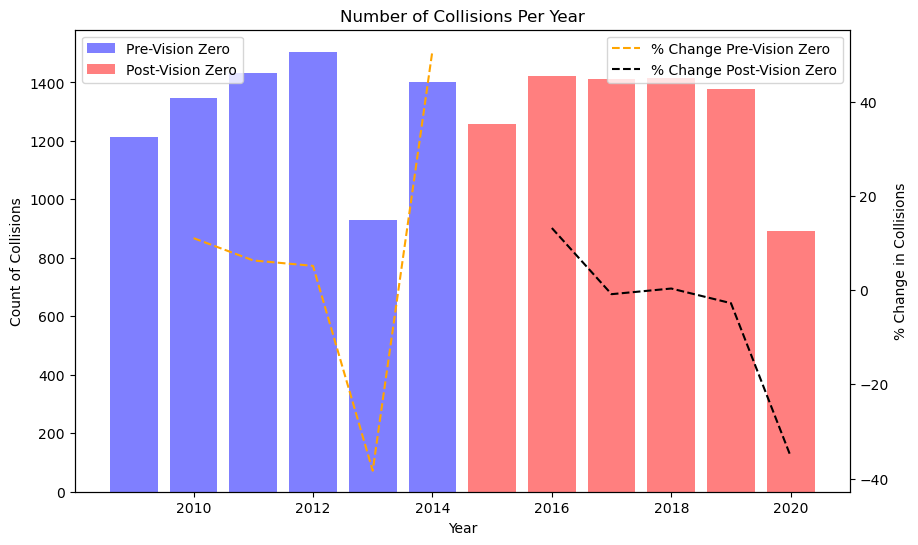

In [4]:
# Group the data by year and sum the total number of collisions for each year
pre_vz_collision_counts = pre_vision_zero.groupby(pre_vision_zero['year'].dt.year)['total_col'].sum()
post_vz_collision_counts = post_vision_zero.groupby(post_vision_zero['year'].dt.year)['total_col'].sum()

# Calculate the percentage change for both groups
pre_vz_collision_pct_change = pre_vz_collision_counts.pct_change() * 100
post_vz_collision_pct_change = post_vz_collision_counts.pct_change() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for collision counts
ax1.bar(pre_vz_collision_counts.index, pre_vz_collision_counts, color='blue', alpha=0.5, label='Pre-Vision Zero')
ax1.bar(post_vz_collision_counts.index, post_vz_collision_counts, color='red', alpha=0.5, label='Post-Vision Zero')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count of Collisions')
ax1.set_title('Number of Collisions Per Year')
ax1.legend(loc='upper left')

# Line plot for percentage change
ax2 = ax1.twinx()
ax2.plot(pre_vz_collision_pct_change.index, pre_vz_collision_pct_change, color='orange', linestyle='--', label='% Change Pre-Vision Zero')
ax2.plot(post_vz_collision_pct_change.index, post_vz_collision_pct_change, color='black', linestyle='--', label='% Change Post-Vision Zero')
ax2.set_ylabel('% Change in Collisions')
ax2.legend(loc='upper right')

plt.show()

**The visualization reveals opposing trends between the pre and post-Vision Zero periods. A noticeable upward trend is observed in collision counts during the pre-Vision Zero era, followed by a slight downward trend in the post-Vision Zero period. This observation suggests a shift in collision occurrences over time, potentially influenced by the implementation of Vision Zero initiatives.**

Additionally, our visualization indicates two significant dips in collision counts, occurring in 2013 and 2020. While the decline in 2020 can be attributed to the COVID-19 lockdown measures, the decrease observed in 2013 may be attributed to a change in data reporting rules and procedures. Before 2013, collision data was acquired through the Statewide Integrated Traffic Records Systems (SWITRS) from the California Highway Patrol (CHP). However, a shift occurred wherein the San Francisco Police Department (SFPD) directly reported collision data, subsequently validated by both the San Francisco Department of Public Health (SFDPH) and the San Francisco Municipal Transportation Agency (SFMTA). This transition likely contributed to the apparent decrease in collision counts observed in 2013.

## Analyzing Collision Trends: Identifying Streets with the Highest Incidence and Fatalities in San Francisco

### 2. Which street is the most hazardous within San Francisco over the years, in terms of the number of collisions and fatalities?

Before we delve into specific locations, let's take a step back and adopt a holistic view of the total collision count for each street, which we'll need to extract from the 'street_names' column.

In [5]:
# Make a copy of df
db_copy2 = db.copy()

# Extract individual street names from the list in 'street_names' column
street_names_list = db_copy2['street_names'].apply(eval).explode()

# Count the occurrences of each street name
street_name_counts = Counter(street_names_list)

# Convert the Counter object to a dictionary
street_name_counts_dict = dict(street_name_counts)

# Sort the dictionary by values (total count) in descending order
sorted_street_name_counts = dict(sorted(street_name_counts_dict.items(), key=lambda item: item[1], reverse=True))

# Display the total count per street in descending order
print("Total Count of Collisions Per Street:")
for street_name, count in sorted_street_name_counts.items():
    print(f"{street_name}: {count}")

Total Count of Collisions Per Street:
MISSION ST: 849
MARKET ST: 533
GEARY BLVD: 345
FOLSOM ST: 338
POLK ST: 336
03RD ST: 335
CALIFORNIA ST: 295
FULTON ST: 287
VAN NESS AVE: 287
16TH ST: 286
HARRISON ST: 281
VALENCIA ST: 259
17TH ST: 240
HOWARD ST: 220
HYDE ST: 214
OCEAN AVE: 212
LARKIN ST: 210
SUTTER ST: 207
FILLMORE ST: 207
18TH ST: 193
POST ST: 193
24TH ST: 192
TAYLOR ST: 190
DIVISADERO ST: 190
BRYANT ST: 189
POWELL ST: 186
GOLDEN GATE AVE: 186
STOCKTON ST: 183
LEAVENWORTH ST: 183
BUSH ST: 180
19TH AVE: 179
MCALLISTER ST: 178
GOUGH ST: 178
LAGUNA ST: 178
WEBSTER ST: 178
PINE ST: 177
TURK ST: 174
SOUTH VAN NESS AVE: 172
06TH ST: 171
EDDY ST: 170
FRANKLIN ST: 169
ELLIS ST: 167
JONES ST: 162
04TH ST: 161
MASON ST: 160
05TH ST: 159
OFARRELL ST: 159
14TH ST: 159
HAIGHT ST: 157
SAN JOSE AVE: 154
FELL ST: 152
BROADWAY: 146
OAK ST: 146
07TH ST: 145
GEARY ST: 145
GUERRERO ST: 143
STEINER ST: 142
KEARNY ST: 138
COLUMBUS AVE: 136
02ND ST: 134
SACRAMENTO ST: 133
THE EMBARCADERO: 132
GENEVA AVE:

From the output above, we can see that it's a very long dictionary. Let's focus on only the top 5 results.

In [6]:
print("Top 5 Streets with the Highest Total Number of Collisions:", [(street_name, count) for street_name, count in dict(list(sorted_street_name_counts.items())[:5]).items()])

Top 5 Streets with the Highest Total Number of Collisions: [('MISSION ST', 849), ('MARKET ST', 533), ('GEARY BLVD', 345), ('FOLSOM ST', 338), ('POLK ST', 336)]


As a resident of San Francisco, I'm not surprised to see Mission St and Market St having the top collision counts within San Francisco, but what about the fatalities?

In [7]:
# Create a new column called 'total_kill'
db_copy2['total_kill'] = db_copy2['pedkill']+db_copy2['bickill']

# Filter the DataFrame for rows where the 'street_names' column contains 'MISSION ST'
mission_st_data = db_copy2[db_copy2['street_names'].str.contains('MISSION ST')]

# Calculate the total number of kills (pedkill + bickill) for MISSION ST
total_kills = mission_st_data['total_kill'].sum()

print("Total deaths on MISSION ST:", total_kills)

# Filter the DataFrame for rows where the 'street_names' column contains 'MARKET ST'
market_st_data = db_copy2[db_copy2['street_names'].str.contains('MARKET ST')]

# Calculate the total number of kills (pedkill + bickill) for MARKET ST
total_kills_market = market_st_data['total_kill'].sum()

print("Total deaths on MARKET ST:", total_kills_market)

# Filter the DataFrame for rows where the 'street_names' column contains 'GEARY BLVD'
geary_blvd_data = db_copy2[db_copy2['street_names'].str.contains('GEARY BLVD')]

# Calculate the total number of kills (pedkill + bickill) for GEARY BLVD
total_kills_geary = geary_blvd_data['total_kill'].sum()

print("Total deaths on GEARY BLVD:", total_kills_geary)

# Filter the DataFrame for rows where the 'street_names' column contains 'FOLSOM ST'
folsom_st_data = db_copy2[db_copy2['street_names'].str.contains('FOLSOM ST')]

# Calculate the total number of kills (pedkill + bickill) for FOLSOM ST
total_kills_folsom = folsom_st_data['total_kill'].sum()

print("Total deaths on FOLSOM ST:", total_kills_folsom)

# Filter the DataFrame for rows where the 'street_names' column contains 'POLK ST'
polk_st_data = db_copy2[db_copy2['street_names'].str.contains('POLK ST')]

# Calculate the total number of kills (pedkill + bickill) for POLK ST
total_kills_polk = polk_st_data['total_kill'].sum()

print("Total deaths on POLK ST:", total_kills_polk)

Total deaths on MISSION ST: 26
Total deaths on MARKET ST: 13
Total deaths on GEARY BLVD: 16
Total deaths on FOLSOM ST: 8
Total deaths on POLK ST: 5


The output indicates that Mission St continues to have the highest number of fatalities among the top five streets with the most collisions in San Francisco. However, this does not necessarily imply that it is the most lethal street, as each street has distinct collision and fatality counts.

To perform a meaningful comparison of fatalities, it's imperative to compute the fatalities per collision for each street in question.

In [8]:
# Calculate the collision count for each street in another way
collision_count_mission_st = len(mission_st_data)
collision_count_market_st = len(market_st_data)
collision_count_geary_blvd = len(geary_blvd_data)
collision_count_folsom_st = len(folsom_st_data)
collision_count_polk_st = len(polk_st_data)

# Calculate fatalities per collision for each street
fatalities_per_collision_mission_st = total_kills / collision_count_mission_st
fatalities_per_collision_market_st = total_kills_market / collision_count_market_st
fatalities_per_collision_geary_blvd = total_kills_geary / collision_count_geary_blvd
fatalities_per_collision_folsom_st = total_kills_folsom / collision_count_folsom_st
fatalities_per_collision_polk_st = total_kills_polk / collision_count_polk_st

# Round the fatalities per collision to a percentage and then to two decimal places
fatalities_per_collision_mission_st = round(fatalities_per_collision_mission_st * 100, 2)
fatalities_per_collision_market_st = round(fatalities_per_collision_market_st * 100, 2)
fatalities_per_collision_geary_blvd = round(fatalities_per_collision_geary_blvd * 100, 2)
fatalities_per_collision_folsom_st = round(fatalities_per_collision_folsom_st * 100, 2)
fatalities_per_collision_polk_st = round(fatalities_per_collision_polk_st * 100, 2)

print("Fatalities per collision on MISSION ST: {:.2f}%".format(fatalities_per_collision_mission_st))
print("Fatalities per collision on MARKET ST: {:.2f}%".format(fatalities_per_collision_market_st))
print("Fatalities per collision on GEARY BLVD: {:.2f}%".format(fatalities_per_collision_geary_blvd))
print("Fatalities per collision on FOLSOM ST: {:.2f}%".format(fatalities_per_collision_folsom_st))
print("Fatalities per collision on POLK ST: {:.2f}%".format(fatalities_per_collision_polk_st))

Fatalities per collision on MISSION ST: 3.06%
Fatalities per collision on MARKET ST: 2.44%
Fatalities per collision on GEARY BLVD: 4.64%
Fatalities per collision on FOLSOM ST: 2.37%
Fatalities per collision on POLK ST: 1.49%


The output reveals that while Mission St has the highest collision counts, it does not have the highest fatality rate. This suggests that despite the high number of collisions occurring on Mission St, the proportion of those collisions resulting in fatalities is relatively lower than on Geary Blvd. This could imply that the collisions on Mission St are less severe on average compared to those on Geary Blvd, which has fewer collisions but higher fatality rates. Possible reasons for this discrepancy could include differences in speed limits, road infrastructure, and the presence of safety measures such as crosswalks or traffic signals.

It's worth noting that this comparison is based on only five streets within San Francisco, and may not accurately represent the street with the highest fatality rate across the entire city. However, by iterating through all unique street names in the database, we can obtain a more comprehensive understanding of collision patterns and fatality rates throughout San Francisco. This approach allows for a more thorough analysis of traffic safety across various locations within the city.

In [9]:
# Create a new column for total number of collisions
db_copy2['total_col'] = db_copy2['biccol'] + db_copy2['pedcol']

# Create an empty dictionary to store the highest fatalities per collision for each street
highest_fatalities_per_collision = {}

# Iterate through unique street names in the DataFrame
for street_name in db_copy2['street_names'].unique():
    # Escape special characters in the street name
    escaped_street_name = re.escape(street_name)

    # Filter the DataFrame for rows where the 'street_names' column matches the current street name
    street_data = db_copy2[db_copy2['street_names'].str.contains(escaped_street_name)]

    # Calculate total fatalities and collision counts for each street
    total_fatalities = street_data['total_kill'].sum()
    total_collisions = street_data['total_col'].sum()

    # Calculate fatalities per collision for the street
    if total_collisions > 0:
        fatalities_per_collision = total_fatalities / total_collisions
    else:
        fatalities_per_collision = 0

    # Update the dictionary with the highest fatalities per collision for the current street
    highest_fatalities_per_collision[street_name] = fatalities_per_collision

# Find the street with the highest fatalities per collision
highest_street = max(highest_fatalities_per_collision, key=highest_fatalities_per_collision.get)
highest_fatalities = highest_fatalities_per_collision[highest_street]

print("Street with the highest fatalities per collision:", highest_street)
print("Highest fatalities per collision:", highest_fatalities)

Street with the highest fatalities per collision: ['TENNESSEE ST', 'TULARE ST']
Highest fatalities per collision: 1.0


The output suggests Tennessee St and Tulare St are the two streets that have the highest fatalities per collision, both sitting at 1.0 or 100%, meaning every collision on Tennessee St and Tulare St is so severe that results in a fatality.

That being said, let's look into the total deaths on these two streets to understand what is the exact total fatalities over the years (2006-2022).

In [10]:
# Filter the DataFrame for rows where the 'street_names' column contains 'MISSION ST'
TN_st_data = db_copy2[db_copy2['street_names'].str.contains('TENNESSEE ST')]

# Calculate the total number of kills (pedkill + bickill) for MISSION ST
total_kills = TN_st_data['total_kill'].sum()

print("Total deaths on TENNESSEE ST:", total_kills)

# Filter the DataFrame for rows where the 'street_names' column contains 'MISSION ST'
TULARE_st_data = db_copy2[db_copy2['street_names'].str.contains('TULARE ST')]

# Calculate the total number of kills (pedkill + bickill) for MISSION ST
total_killsTUL = TULARE_st_data['total_kill'].sum()

print("Total deaths on TULARE ST:", total_killsTUL)

Total deaths on TENNESSEE ST: 1
Total deaths on TULARE ST: 1


The output indicates that both streets only have one death over the years (2006-2022) and highlights the importance of considering both the total number of deaths and the fatalities per collision ratio to gain a comprehensive understanding of the severity of traffic incidents on different streets. While one street may have a higher total number of deaths, the likelihood of a collision resulting in a fatality may vary significantly between streets.

**Based on the available data, we cannot conclusively determine which street is more dangerous. A more comprehensive analysis is required, taking into account additional factors beyond just the fatality rate per collision and total number of deaths.**

## Comparing Fatality Rates: Pedestrian vs. Bicycle Accidents

### 3. How do pedestrian and bicycle accidents compare in terms of fatality rates? Is there a notable difference in outcomes for pedestrians versus cyclists?

Let's dig deeper into the data and compare between pedestrian and bicycle collisions to see whether if one is higher than the other?

In [11]:
# Make a copy of df
db_copy3 = db.copy()

# Calculate fatality rates for pedestrians and cyclists
pedestrian_fatality_rate = (db_copy3['pedkill'].sum() / db_copy3['pedcol'].sum()) * 100
cyclist_fatality_rate = (db_copy3['bickill'].sum() / db_copy3['biccol'].sum()) * 100

# Compare fatality rates
pedestrian_fatality_rate = (round(pedestrian_fatality_rate, 2))
cyclist_fatality_rate = (round(cyclist_fatality_rate, 2))

# Print fatality rates for pedestrians and cyclists
print("Fatality Rates:")
print(f"Pedestrian Fatality Rate: {pedestrian_fatality_rate}%")
print(f"Cyclist Fatality Rate: {cyclist_fatality_rate}%")


Fatality Rates:
Pedestrian Fatality Rate: 2.38%
Cyclist Fatality Rate: 0.44%


The fatal incidents percentage of 2.38 for pedestrians implies that approximately 2.38% of all collisions involving pedestrians resulted in fatalities. Similarly, the fatal incidents percentage of 0.44 for cyclists suggests that around 0.44% of incidents involving cyclists led to fatalities.

**From the data, it's evident that pedestrian collisions have a higher fatality rate compared to bicycle collisions.**

One of the purposes of collecting latitude and longitude data is to aid visualization. Before visualizing the data, let's present a table with a cleaned header.

In [12]:
# Create new columns for total kills and total injuries for more graphs later
db_copy2['Total Death'] = db_copy2['bickill'] + db_copy2['pedkill']
db_copy2['Total Injury'] = db_copy2['bicinj'] + db_copy2['pedinj']
db_copy2['Total Pedestrain Death'] = db_copy2['pedkill']
db_copy2['Total Pedestrain Injury'] = db_copy2['pedinj']
db_copy2['Total Bicycle Death'] = db_copy2['bickill']
db_copy2['Total Bicycle Injury'] = db_copy2['bicinj']
db_copy2['Street Names'] = db_copy2['street_names']

# Convert the date column to datetime format
db_copy2['year'] = pd.to_datetime(db_copy2['year'], format='%Y')

# Return a new df
selected_data = db_copy2[['year', 'intersection_lat', 'intersection_lon', 'pedcol', 'biccol', 'pedkill', 'pedinj', 'bickill', 'bicinj']]

# Renaming the columns for better readability
selected_data.columns = ['YEAR', 'LATITUDE', 'LONGITUDE', 'TOTAL PEDESTRIAN COLLISIONS', 'TOTAL BICYCLE COLLISIONS', 'TOTAL PEDESTRIAN DEATH', 'TOTAL PEDESTRIAN INJURY', 'TOTAL BICYCLE DEATH', 'TOTAL BICYCLE INJURY']

# Displaying the DataFrame
display(selected_data)

,YEAR,LATITUDE,LONGITUDE,TOTAL PEDESTRIAN COLLISIONS,TOTAL BICYCLE COLLISIONS,TOTAL PEDESTRIAN DEATH,TOTAL PEDESTRIAN INJURY,TOTAL BICYCLE DEATH,TOTAL BICYCLE INJURY
0,2008-01-01,37.811896,-122.362688,1,0,1,0,0,0
1,2010-01-01,37.811896,-122.362688,1,0,0,1,0,0
2,2011-01-01,37.811902,-122.363147,1,0,0,1,0,0
3,2016-01-01,37.823574,-122.363743,0,1,0,0,0,1
4,2014-01-01,37.807819,-122.367434,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
14626,2017-01-01,37.779410,-122.511424,0,3,0,0,0,3
14627,2018-01-01,37.779410,-122.511424,0,1,0,0,0,1
14628,2019-01-01,37.779410,-122.511424,1,0,0,1,0,0
14629,2020-01-01,37.779410,-122.511424,0,1,0,0,0,1


### Conclusion

In conclusion, we've addressed all three questions, although the second remains inconclusive. Regarding the first question, the visualization illustrates divergent trends before and after the inception of Vision Zero in 2014. Before Vision Zero, collision counts surged, followed by a modest decline post-implementation. Notable dips occurred in 2013 and 2020, with the latter attributed to COVID-19 restrictions. The 2013 decline likely resulted from changes in data reporting, transitioning from SWITRS to direct SFPD reporting. Despite Tennessee St and Tulare St having the highest 'fatalities per collision' at 1.0, each street only had one death from 2006-2022, while Mission St recorded 849 collisions, including 26 deaths at a 0.0306 fatality rate per collision. This underscores the need for a more comprehensive analysis, taking into account additional factors beyond just the fatality rate per collision and total number of deaths. Thus, determining the most perilous street requires a multifaceted analysis. Lastly, pedestrian collisions exhibit a higher fatality rate (2.38%) compared to cyclist incidents (0.44%), highlighting disparate outcomes between pedestrians and cyclists.

That being said, let's render the map data since we have the geom data and to help us visualized the collision data better.

In [13]:
# Diagnose YEAR values and build a safe filter that won't return 0 rows
import pandas as pd
import numpy as np

# Peek YEAR distribution
print("YEAR dtype:", selected_data["YEAR"].dtype)
print("YEAR sample:", selected_data["YEAR"].dropna().unique()[:10])

# Normalize YEAR to numeric
_year_num = pd.to_numeric(selected_data["YEAR"], errors="coerce")

# Try >=2017 (what you originally wanted). If empty, back off to >=2014. If still empty, no date filter.
mask_2017 = _year_num >= 2017
mask_2014 = _year_num >= 2014

if mask_2017.sum() > 0:
    mask = mask_2017
    used_threshold = 2017
elif mask_2014.sum() > 0:
    mask = mask_2014
    used_threshold = 2014
else:
    mask = _year_num.notna()  # no filter
    used_threshold = None

filtered_data = selected_data.loc[mask].copy()
print("year threshold used:", used_threshold)
print("rows after year filter:", len(filtered_data))

YEAR dtype: datetime64[ns]
YEAR sample: <DatetimeArray>
['2008-01-01 00:00:00', '2010-01-01 00:00:00', '2011-01-01 00:00:00',
 '2016-01-01 00:00:00', '2014-01-01 00:00:00', '2020-01-01 00:00:00',
 '2022-01-01 00:00:00', '2007-01-01 00:00:00', '2015-01-01 00:00:00',
 '2018-01-01 00:00:00']
Length: 10, dtype: datetime64[ns]
year threshold used: 2017
rows after year filter: 14631


In [14]:
import plotly.io as pio, plotly.express as px
import pandas as pd

# ---- required columns ----
LAT_COL = "LATITUDE" # expected column name for latitude
LON_COL = "LONGITUDE" # expected column name for longitude

# Use existing filtered_data as-is by making a copy
plot_df = filtered_data.copy()

# Hard fail if columns missing
missing = [c for c in (LAT_COL, LON_COL) if c not in plot_df.columns]
if missing:
    # Stop execution immediately if required columns aren't in the dataset
    raise KeyError(f"Missing required columns: {missing}")

# Enforce numeric, but NO sign flipping or guessing
plot_df[LAT_COL] = pd.to_numeric(plot_df[LAT_COL], errors="coerce")
plot_df[LON_COL] = pd.to_numeric(plot_df[LON_COL], errors="coerce")

# Sanity Check: SF longitudes should be around -122.x
if plot_df[LON_COL].dropna().median() > 0:
    raise ValueError(
        f"{LON_COL} looks positive (median={plot_df[LON_COL].median():.3f}). "
        "Your data likely stores +122 instead of -122. Fix your source or negate it explicitly."
    )

# Keep a strict SF bbox
plot_df = plot_df[
    plot_df[LAT_COL].between(37.60, 37.88) # latitude range
    & plot_df[LON_COL].between(-122.55, -122.33) # longitude range
].dropna(subset=[LAT_COL, LON_COL]) # Drop NA rows

# Final Check: are rows actually being plotted?
print("rows plotted:", len(plot_df))


rows plotted: 14631


In [15]:
#%pip install -q plotly
import pandas as pd
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab" 

# --- explicit columns ---
LAT_COL = "LATITUDE"
LON_COL = "LONGITUDE"
PED_COL = "TOTAL PEDESTRIAN COLLISIONS"
BIK_COL = "TOTAL BICYCLE COLLISIONS"

# Create a copy of df and keeping only the columns needed for plotting
plot_df = filtered_data[[LAT_COL, LON_COL, PED_COL, BIK_COL]].copy()

# Ensure coordinates are numeric and remove points outside the map
plot_df[LAT_COL]  = pd.to_numeric(plot_df[LAT_COL],  errors="coerce")
plot_df[LON_COL]  = pd.to_numeric(plot_df[LON_COL],  errors="coerce")
plot_df = plot_df[
    plot_df[LAT_COL].between(37.60, 37.88) # lat range covering SF
    & plot_df[LON_COL].between(-122.55, -122.33) # lon range covering SF
].dropna(subset=[LAT_COL, LON_COL]) # drop rows with missing coords

# Split layers for toggle
ped_df = plot_df[plot_df[PED_COL] > 0] # only rows with pedestrian collisions
bik_df = plot_df[plot_df[BIK_COL] > 0] # only rows with bicycle collisions

center = {"lat": plot_df[LAT_COL].median(), "lon": plot_df[LON_COL].median()}

# Build ped layer
fig_ped = px.scatter_map(ped_df, lat=LAT_COL, lon=LON_COL,
                         zoom=12, center=center, map_style="open-street-map",
                         height=650, opacity=0.85)
fig_ped.update_traces(name="Pedestrian", marker={"color": "crimson"})

# Build bike layer
fig_bik = px.scatter_map(bik_df, lat=LAT_COL, lon=LON_COL,
                         zoom=12, center=center, map_style="open-street-map",
                         height=650, opacity=0.85)
fig_bik.update_traces(name="Bicycle", marker={"color": "teal"})

# Combine both layers & toggle buttons
fig = fig_ped
for tr in fig_bik.data:  # add bike traces
    fig.add_trace(tr)

# make ped on by default (trace order: [Ped, Bike])
vis = [True, False] if len(fig.data) == 2 else [True] * len(fig.data)
fig.update_traces(visible=vis[0], selector=0)
if len(fig.data) > 1:
    fig.update_traces(visible=vis[1], selector=1)

# Add three buttons above map to toggle the layer
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0), # remove outer padding
    updatemenus=[dict(
        type="buttons", direction="right", x=0.5, y=1.02, xanchor="center", # center the buttons above the figure
        buttons=[
            dict(label="Pedestrian", method="update",
                 args=[{"visible":[True, False]}, {}]), # Show only Ped layer
            dict(label="Bicycle", method="update",
                 args=[{"visible":[False, True]}, {}]), # Show only Bike layer
            dict(label="Both", method="update",
                 args=[{"visible":[True, True]}, {}]), # Show both layers
        ]
    )]
)

# Render map
fig.show(renderer="notebook_connected")


**Above is the Collision Incidents Map of San Francisco between 2014-2022 for pedestrain and bicycle**

### Problems Encountered

**1. Have collision trends shown any significant changes over time, particularly around the adoption of Vision Zero in 2014?**  
Initially, my goal was to analyze collision trends during the COVID-19 era alongside examining the adoption of Vision Zero in 2014. This analysis would be divided into two distinct time frames: the 'lockdown' period (from the announcement of California's stay-at-home order on March 15, 2020, to its complete reopening on June 15, 2021) and the 'post-COVID' period (following the state's full reopening on June 15, 2021). It's worth noting that both periods would have shared a similar duration, given the inclusion of recent data, extending up to the entirety of 2022 (although displayed as 2022-01-01).

However, upon further consideration, it becomes evident that calculating the average percentage change for both the 'lockdown' and 'post-COVID' periods poses a challenge. This limitation arises because these periods each encompass only about one year of data, and the dataset records collisions solely by year without precise dates. Consequently, conducting accurate data calculations for these periods becomes impractical due to potential overlaps in collision data.

**2. Which street is the most hazardous within San Francisco over the years, in terms of the number of collisions and fatalities?**  
My initial assumption was that I could identify the most fatal street(s) in San Francisco over the years based on the available data. However, I was surprised to find that the top 5 streets with the most collisions are not even half as fatal as Tennessee St and Tulare St, despite both streets having only one fatality count over the years (2006-2022). Due to this discrepancy, we cannot concretely determine which street is more dangerous with just this dataset.

### Suggestion For Future Research:

Future research could benefit from collaborative efforts with the Vision Zero Task Force, comprising members from the San Francisco Municipal Transportation Agency (SFMTA) and the San Francisco Department of Public Health (SFDPH). It's recommended to advocate for the collection and public release of data pertaining to the Vision Zero High-Injury Network and SFMTA’s Bike Program. This data would provide valuable insights for future researchers seeking to evaluate the efficacy of pedestrian and bicycle safety enhancement initiatives implemented throughout San Francisco. Access to comprehensive data sets would enable in-depth analyses of the impact of various safety improvement projects, aiding in the development of evidence-based strategies to further enhance road safety in the city.